### Natural Language Processing on COVID-19 medical literature papers
Yingying Zhou   University of Toronto   Faculty of Information
<br> yingying.zhou@mail.utoronto.ca </br>

### 1. Data Cleanning

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models


from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('metadata.csv')
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
# load the meta data from the CSV file and extract out fields that will be useful to our application
df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df.head()

,title,abstract,authors,publish_time
0,Clinical features of culture-proven Mycoplasma...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11


In [4]:
df.shape

(321013, 4)

Since the inception of COVID-19 outbreak was first reported on 31 December 2019, papers prior to the date are assumed to be irrelevant to COVID-19, I filtered out those rows and construct a dataframe on `COVID-19`. 

In [5]:
len(df[df['publish_time']>='2020-01-01'])

150055

In [6]:
df_covid = df[df['publish_time']>='2020-01-01']
df_covid.head()

,title,abstract,authors,publish_time
4248,Dexmedetomidine improved renal function in pat...,background: dexmedetomidine has been reported ...,"Nakashima, Tsuyoshi; Miyamoto, Kyohei; Shima, ...",2020-01-02
4249,Aortic volume determines global end-diastolic ...,background: global end-diastolic volume (gedv)...,"Akohov, Aleksej; Barner, Christoph; Grimmer, S...",2020-01-02
4250,Whole genome sequencing and phylogenetic analy...,background: human metapneumovirus (hmpv) is an...,"Kamau, Everlyn; Oketch, John W.; de Laurent, Z...",2020-01-02
4251,European intensive care physicians’ experience...,background: antimicrobial resistance (amr) com...,"Lepape, Alain; Jean, Astrid; De Waele, Jan; Fr...",2020-01-02
4252,Synthetic carbohydrate-based vaccines: challen...,glycoconjugate vaccines based on bacterial cap...,"Mettu, Ravinder; Chen, Chiang-Yun; Wu, Chung-Yi",2020-01-03


In [17]:
# add a column for publish year
df_covid['publish_year']= pd.DatetimeIndex(df_covid['publish_time']).year
df_covid.head()

,title,abstract,authors,publish_time,publish_year
4248,Dexmedetomidine improved renal function in pat...,background: dexmedetomidine has been reported ...,"Nakashima, Tsuyoshi; Miyamoto, Kyohei; Shima, ...",2020-01-02,2020
4249,Aortic volume determines global end-diastolic ...,background: global end-diastolic volume (gedv)...,"Akohov, Aleksej; Barner, Christoph; Grimmer, S...",2020-01-02,2020
4250,Whole genome sequencing and phylogenetic analy...,background: human metapneumovirus (hmpv) is an...,"Kamau, Everlyn; Oketch, John W.; de Laurent, Z...",2020-01-02,2020
4251,European intensive care physicians’ experience...,background: antimicrobial resistance (amr) com...,"Lepape, Alain; Jean, Astrid; De Waele, Jan; Fr...",2020-01-02,2020
4252,Synthetic carbohydrate-based vaccines: challen...,glycoconjugate vaccines based on bacterial cap...,"Mettu, Ravinder; Chen, Chiang-Yun; Wu, Chung-Yi",2020-01-03,2020


In [27]:
df_covid['publish_monyr'] = pd.to_datetime(df_covid['publish_time']).dt.to_period('M')
df_covid.head()

,title,abstract,authors,publish_time,publish_year,publish_monyr
4248,Dexmedetomidine improved renal function in pat...,background: dexmedetomidine has been reported ...,"Nakashima, Tsuyoshi; Miyamoto, Kyohei; Shima, ...",2020-01-02,2020,2020-01
4249,Aortic volume determines global end-diastolic ...,background: global end-diastolic volume (gedv)...,"Akohov, Aleksej; Barner, Christoph; Grimmer, S...",2020-01-02,2020,2020-01
4250,Whole genome sequencing and phylogenetic analy...,background: human metapneumovirus (hmpv) is an...,"Kamau, Everlyn; Oketch, John W.; de Laurent, Z...",2020-01-02,2020,2020-01
4251,European intensive care physicians’ experience...,background: antimicrobial resistance (amr) com...,"Lepape, Alain; Jean, Astrid; De Waele, Jan; Fr...",2020-01-02,2020,2020-01
4252,Synthetic carbohydrate-based vaccines: challen...,glycoconjugate vaccines based on bacterial cap...,"Mettu, Ravinder; Chen, Chiang-Yun; Wu, Chung-Yi",2020-01-03,2020,2020-01


### 2. Data Visualization & Exploratory Data Analysis

**Distribution of published papers over time**

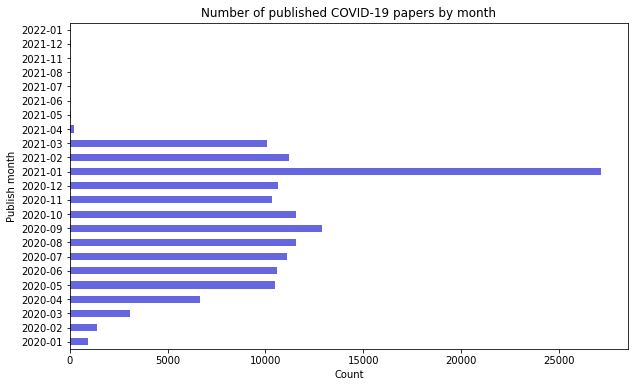

In [87]:
plt.figure(figsize=(10,6))
monyr_pub = df_covid.groupby('publish_monyr')['publish_monyr'].count()
monyr_pub.plot.barh(rot=0, color='mediumblue', alpha=0.6)
plt.xlabel('Count')
plt.ylabel('Publish month')
plt.title('Number of published COVID-19 papers by month')
plt.show()

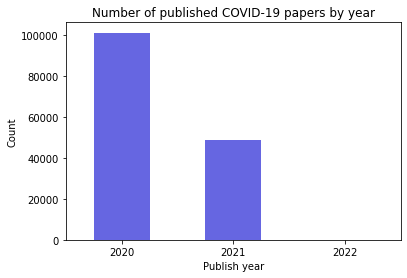

In [88]:
annual_pub = df_covid.groupby('publish_year')['publish_year'].count()
annual_pub.plot.bar(rot=0, color='mediumblue', alpha=0.6)
plt.xlabel('Publish year')
plt.ylabel('Count')
plt.title('Number of published COVID-19 papers by year')
plt.show()

Since the Novel Coronavirus (COVID-19) outbreak on Decemeber 31st 2019, researchers are sparing no effort to investigate about this highly-contagious pandemic in order to find the ultimate cure for mankind. So far there has been over 150,000 related papers issued, and January 2021 witnesses a jump in the number of published COVID-19 papers at its "one-year anniversary".

**Check how many COVID-19 papers are related to vaccine💉**

In [123]:
vaccine_df1 = df_covid[df_covid['abstract'].str.contains("vaccine", regex=False)]
vaccine_df1.shape

(9253, 6)

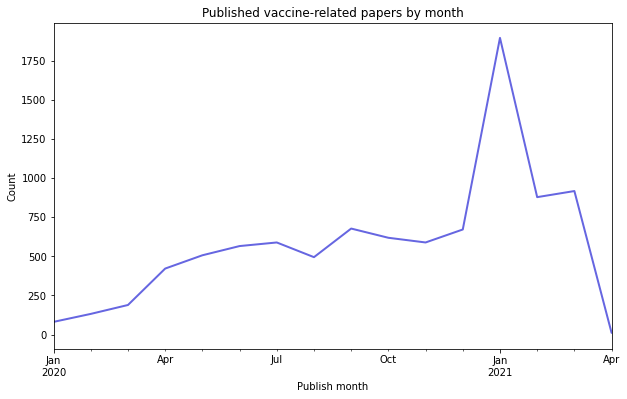

In [124]:
monyr_pub1 = vaccine_df1.groupby('publish_monyr')['publish_monyr'].count()
monyr_pub1.plot.line(figsize=(10,6),label='publish_month', color='mediumblue', alpha=0.6, lw=2)
plt.xlabel('Publish month')
plt.ylabel('Count')
plt.title('Published vaccine-related papers by month')
plt.xlim('2020-01','2021-04')
plt.show()

The timeline for the vaccine paper release somehow echos with the [vaccine development timeline](https://www.biopharmadive.com/news/coronavirus-vaccine-pipeline-types/579122/). 
<br>It is observed that the first rise in the number of vaccine related paper happens in March, when the major 5 pharmaceutical companies (Pfizer, BioNTech, Moderna, AstraZeneca, and Novavax) announced their vaccine developments plan and released experiment reports. The number of publications addressing COVID-19 vaccine peaked in January 2021, prior to their large-scale vaccine production.</br>

Notice that among the published hundreds of thousands of papers, papers related to vaccine account for only 6%. 

**Visualize the top frequent words in the COVID-19 paper abstracts**

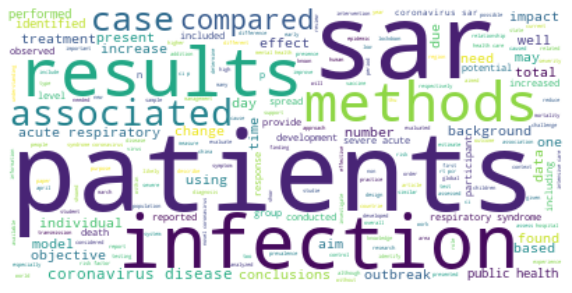

In [48]:
# create a word cloud to visualize the most frequent key words in the paper abstracts on COVID-19
plt.figure(figsize=(10,6))
text = " ".join(ab for ab in df_covid['abstract'])
stopwords = set(STOPWORDS)
stopwords.update(["covid", "cov", "result", "conclusion", "used", "use", "study" ,'method','patient','pandemic'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Visualize the top frequent words in the COVID-19 paper titles**

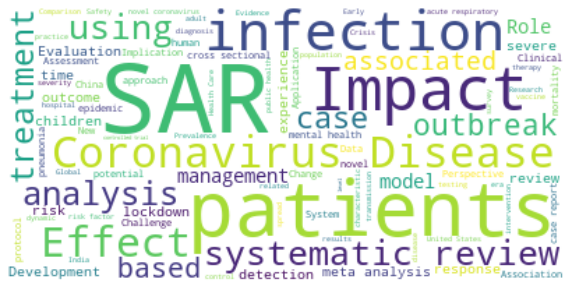

In [49]:
# create a word cloud to visualize the top frequent keywords in the paper titles on COVID-19
plt.figure(figsize=(10,6))
text = " ".join(ab for ab in df_covid['title'])
stopwords = set(STOPWORDS)
stopwords.update(["covid", "cov", "result", "conclusion", "used", "use", "study" ,'method','patient','pandemic'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

After removing the specific common words for COVID-19 and research papers (i.e. covid, pandemic, study, etc.), we can see that the most mentioned words are SARS, patients, infection, impact, treatment, effect and so on, which are problem-solving-oriented, aiming to study the subject matter so as to cure mankind of the Novel coronavirus pandemic.    

Besides the big pitcure shown by word clouds on the top keywords for paper abstract and title, the next question is what topic dimension are those papers focusing on, what areas have been studied thoroughly, and which topic needs the most attention? 

The questions above motivate me to explore the COVID-19 literature papers through **topic mining**.  Consequently, I would be able to gain insights on the current medical research landscape to better inform how our healthcare system, governments, industries can fight against COVID-19.

### 3. Modeling: Topic modelling using Latent Dirichlet Allocation (LDA)
**Topic mining on COVID-19 scientific papers**
<br>source code: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#15visualizethetopicskeywords</br>
<br> Gensim documentation: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

Topic Modeling is a technique to extract the hidden topics from large volumes of text through conducting Dimensionality Reduction, Unsupervised Learning, and Tagging on the given texts. 
<br>This project uses the **Latent Dirichlet Allocation model** to mine the topics in the COVID-19 medical research papers published after 2020.</br>

### Create Bigram and Trigram Models

In [54]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_covid.abstract.values.tolist()
data_words = list(sent_to_words(data))

In [55]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['background', 'dexmedetomidine', 'has', 'been', 'reported', 'to', 'improve', 'organ_dysfunction', 'in', 'critically_ill', 'patients', 'in', 'recent', 'randomized_controlled_trial', 'dexmedetomidine', 'for', 'sepsis', 'in', 'intensive', 'care', 'unit_icu', 'randomized', 'evolution', 'desire', 'we', 'demonstrated', 'that', 'dexmedetomidine', 'was', 'associated', 'with', 'reduced', 'mortality', 'risk', 'among', 'patients', 'with', 'severe', 'sepsis', 'we', 'performed', 'this', 'exploratory', 'sub', 'analysis', 'to', 'examine', 'the', 'mechanism', 'underlying', 'improved', 'survival', 'in', 'patients', 'sedated', 'with', 'dexmedetomidine', 'methods', 'the', 'desire', 'trial', 'compared', 'sedation', 'strategy', 'with', 'and', 'without', 'dexmedetomidine', 'among', 'mechanically_ventilated', 'adult', 'patients', 'with', 'sepsis', 'across', 'eight', 'icus', 'in', 'japan', 'in', 'the', 'present', 'study', 'we', 'included', 'patients', 'with', 'acute', 'physiology', 'and', 'chronic', 'health'

In [62]:
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'cov', 'result', 'conclusion', 'used','use','study','method','patients','pandemic',\
                   'disease','coronavirus','case','data','model','also','research','paper'])


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatize the documents
def lemm(texts):
    return [[WordNetLemmatizer().lemmatize(word, pos='v') for word in doc] for doc in texts]

In [63]:
# remove stop words
data_words = remove_stopwords(data_words)

# form bigrams
data_words = make_bigrams(data_words)

# Lemmatization
data_words = lemm(data_words)
print(data_words[:1][0][:30])

['background', 'dexmedetomidine', 'report', 'improve', 'critically_ill', 'recent', 'trial', 'dexmedetomidine', 'sepsis', 'intensive', 'care', 'unit', 'icu', 'randomize', 'evolution', 'desire', 'demonstrate', 'dexmedetomidine', 'associate', 'reduce', 'mortality', 'risk', 'among', 'severe', 'sepsis', 'perform', 'exploratory', 'sub', 'analysis', 'examine']


In [64]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Filter out words that occur less than 20 documents, or more than 50% of the documents
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 2), (7, 1), (8, 2), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 2), (22, 1), (23, 2), (24, 5), (25, 7), (26, 1), (27, 1), (28, 1), (29, 1)]


**Build the LDA model**

set number of topics to be 10, set number of keywords to view by 20

In [65]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=116)

### Compute Coherence Score

In [67]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39209841114899013


**Find the optimal number of topics for LDA**

In [154]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=116)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [155]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=15, step=2)

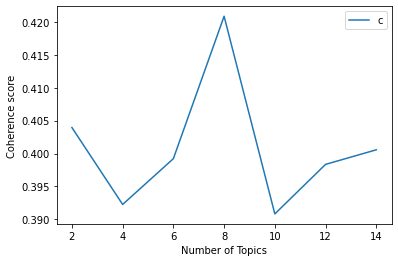

In [156]:
# show graph
limit=15; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Therefore, the best LDA model has 8 topics.

**Build the best model**

In [157]:
# number of topics
num_topics = 8

# Build the best LDA model
best_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=116)

In [158]:
pprint(best_model.show_topics(num_topics=8,num_words=20))

[(0,
  '0.012*"health" + 0.008*"test" + 0.006*"risk" + 0.006*"report" + '
  '0.006*"sars" + 0.005*"ci" + 0.005*"among" + 0.005*"participants" + '
  '0.005*"increase" + 0.005*"anxiety" + 0.005*"symptoms" + 0.004*"level" + '
  '0.004*"find" + 0.004*"mental" + 0.004*"social" + 0.004*"age" + '
  '0.004*"associate" + 0.004*"time" + 0.004*"methods" + 0.004*"include"'),
 (1,
  '0.009*"cells" + 0.008*"de" + 0.007*"cell" + 0.005*"sars" + '
  '0.005*"infection" + 0.005*"expression" + 0.004*"protein" + 0.004*"virus" + '
  '0.004*"show" + 0.003*"may" + 0.003*"viral" + 0.003*"human" + 0.003*"immune" '
  '+ 0.003*"include" + 0.003*"analysis" + 0.003*"find" + 0.003*"increase" + '
  '0.003*"la" + 0.003*"target" + 0.003*"response"'),
 (2,
  '0.015*"sars" + 0.010*"health" + 0.007*"drug" + 0.005*"virus" + '
  '0.004*"human" + 0.004*"include" + 0.004*"viral" + 0.004*"review" + '
  '0.004*"base" + 0.004*"transmission" + 0.003*"potential" + 0.003*"find" + '
  '0.003*"report" + 0.003*"spread" + 0.003*"increa

### Visualize the topics in LDA model

Notice that the topics are ranked by number of occurrences in the abstracts instead of topic number output by the LDA model. 

In [159]:
pyLDAvis.enable_notebook()
vis_best = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
vis_best

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.056698 -0.009752       1        1  16.584977
0     -0.064172  0.000941       2        1  14.054657
7     -0.025743 -0.028995       3        1  13.377538
6     -0.020587  0.081682       4        1  12.474611
4      0.026299  0.040624       5        1  11.988410
5      0.008309 -0.050736       6        1  11.698153
1      0.105444  0.009101       7        1  10.876761
2      0.027150 -0.042864       8        1   8.944893, topic_info=             Term          Freq         Total Category  logprob  loglift
3749         sars  96209.000000  96209.000000  Default  30.0000  30.0000
1045           de  18388.000000  18388.000000  Default  29.0000  29.0000
439         cells  25273.000000  25273.000000  Default  28.0000  28.0000
38         health  88359.000000  88359.000000  Default  27.0000  27.0000
238   respiratory  37189.000000  37189.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
590     infection   4790.250636  59669.416945   Topic8  -5.7126  -0.1081
476           new   3806.971412  29465.278118   Topic8  -5.9424   0.3677
546          need   4012.212988  35393.712989   Topic8  -5.8899   0.2369
344       control   3847.326760  37092.742893   Topic8  -5.9318   0.1480
200      clinical   3881.732406  58916.874903   Topic8  -5.9229  -0.3058

[796 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
4431       1  0.012495        ace
4431       2  0.009530        ace
4431       3  0.006036        ace
4431       4  0.052735        ace
4431       5  0.108012        ace
...      ...       ...        ...
101        7  0.045169      years
101        8  0.039194      years
18862      2  0.948491  zung_self
18862      3  0.023134  zung_self
18862      4  0.023134  zung_self

[3957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 8, 7, 5, 6, 2, 3])

In [160]:
pyLDAvis.save_html(vis_best, './ldatopics_vis.html')

### Find the dominant topic for each paper abstract

In [78]:
def format_topics_document(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [161]:
df_topic_best_keywords = format_topics_document(ldamodel=best_model, corpus=corpus, texts=data)
df_topic_best_keywords.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# convert topic number to integer
df_topic_best_keywords['Dominant_Topic'] = df_topic_best_keywords['Dominant_Topic'].astype(int)
df_topic_best_keywords.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,6,0.9323,"group, age, clinical, level, severe, ci, assoc...",background: dexmedetomidine has been reported ...
1,6,0.4711,"group, age, clinical, level, severe, ci, assoc...",background: global end-diastolic volume (gedv)...
2,4,0.5976,"sars, infection, respiratory, severe, clinical...",background: human metapneumovirus (hmpv) is an...
3,3,0.5586,"care, patient, clinical, treatment, health, in...",background: antimicrobial resistance (amr) com...
4,5,0.8040,"health, base, test, include, provide, systems,...",glycoconjugate vaccines based on bacterial cap...
5,3,0.8539,"care, patient, clinical, treatment, health, in...",background: acute kidney injury (aki) is a com...
6,1,0.6089,"cells, de, cell, sars, infection, expression, ...",mycobacterium tuberculosis (m.tb) is responsib...
7,1,0.6460,"cells, de, cell, sars, infection, expression, ...",a wide range of cancer immunotherapy approache...
8,7,0.5557,"number, time, health, increase, countries, rat...",background: an efficient surface cleaning stra...
9,0,0.7975,"health, test, risk, report, sars, ci, among, p...",background: general self-efficacy is considere...


**Summarize 8 topics into meaningful labels based on their salient key words**

Topic 0 : anxiety, mental, depression -> `mental health`
<br>Topic 1: cell, expression, protein, genes -> `virus genetics`</br>
<br>Topic 2: drug, effect -> `drug`</br>
<br>Topic 3: care, patient, clinical, treatment -> `medical care`</br>
<br>Topic 4: sars, infection, respiratory, syndrome -> `diagnostics`</br>
<br>Topic 5: base, test -> `test`</br>
<br>Topic 6: age, severe, years, mortality -> `patient description`
<br>Topic 7: countries, epidemic, population, public -> `population studies`</br>


In [164]:
# map the 8 numeric topic numbers to its corresponding text label
topic_map_best = {0: 'mental health',
            1: 'virus genetics',
            2: 'drug',
            3: 'medical care',
            4: 'diagnostics',
            5: 'test',
            6: 'patient description',
            7: 'population studies'}

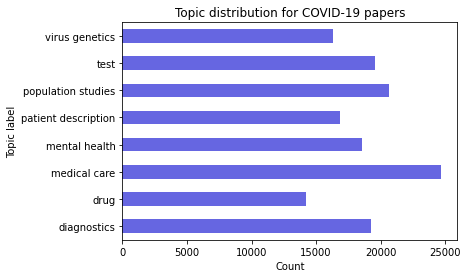

In [165]:
df_topic_best_keywords['Dominant_Topic_Label'] = df_topic_best_keywords['Dominant_Topic'].map(topic_map_best)
topic_label_countb = df_topic_best_keywords.groupby('Dominant_Topic_Label')['Dominant_Topic_Label'].count()
topic_label_countb.plot.barh(rot=0, color='mediumblue', alpha=0.6)
plt.xlabel('Count')
plt.ylabel('Topic label')
plt.title('Topic distribution for COVID-19 papers')
plt.show()

There are eight topics (`mental health`, `virus genetics`, `drug`, `medical care`, `diagnotics`, `test`, `patient description`, and `population studies`) identified from the COVID-19 biomedical literaure dataset by the LDA model. 

Amongst them, the field of **drug** (i.e. vaccine development and therapeutics) has been studied the least. Perhaps it is because that it takes significant amount of time for drug development such as vaccine and therapeutics, from experimental design, model building to clinical tests. In addition, the drug development needs to be based on theoretical and clinical evidence from other research papers, which justifies for its low publish number. 

### Sub-topic mining on vaccine related papers
Next, let's further explore the sub-topics in the vaccine related papers. What aspects have they addressed in detail? Are they similar in nature?

In [130]:
vac_data = vaccine_df1.abstract.values.tolist()
vac_data_words = list(sent_to_words(vac_data))

# build bigram and trigram models
vac_bigram = gensim.models.Phrases(vac_data_words, min_count=5, threshold=60)
vac_trigram = gensim.models.Phrases(vac_bigram[vac_data_words], threshold=60)

vac_bigram_mod = gensim.models.phrases.Phraser(vac_bigram)
vac_trigram_mod = gensim.models.phrases.Phraser(vac_trigram)

In [146]:
stop_words = stopwords.words('english')
stop_words.extend(['covid','cov','vaccine','pandemic','study','disease','vaccination','vaccines','use','coronavirus','also','research','may'])

# remove stop words
vac_data_words = remove_stopwords(vac_data_words)

# form bigrams
vac_data_words = make_bigrams(vac_data_words)

# Lemmatization
vac_data_words = lemm(vac_data_words)

In [147]:
# create dictionary for vaccine data
id2word_vac = corpora.Dictionary(vac_data_words)

# create corpus
vac_texts = vac_data_words

# term document frequency
vac_corpus = [id2word_vac.doc2bow(vac_text) for vac_text in vac_texts]

In [150]:
# build the LDA model for vaccine data
n_topics = 5

lda_model_vac = gensim.models.LdaMulticore(corpus=vac_corpus,
                                          id2word=id2word_vac,
                                          num_topics=n_topics,
                                          random_state=116)

In [151]:
pprint(lda_model_vac.show_topics(num_topics=5, num_words=20))

[(0,
  '0.016*"sars" + 0.006*"infection" + 0.005*"virus" + 0.004*"protein" + '
  '0.004*"immune" + 0.004*"development" + 0.004*"result" + 0.004*"include" + '
  '0.004*"patients" + 0.004*"respiratory" + 0.004*"dose" + 0.004*"human" + '
  '0.004*"effective" + 0.004*"severe" + 0.003*"responses" + 0.003*"show" + '
  '0.003*"target" + 0.003*"report" + 0.003*"viral" + 0.003*"clinical"'),
 (1,
  '0.011*"sars" + 0.006*"virus" + 0.005*"cell" + 0.005*"protein" + '
  '0.005*"health" + 0.005*"patients" + 0.004*"result" + 0.004*"infection" + '
  '0.004*"base" + 0.004*"drug" + 0.004*"viral" + 0.004*"test" + '
  '0.004*"development" + 0.003*"identify" + 0.003*"clinical" + 0.003*"cells" + '
  '0.003*"develop" + 0.003*"case" + 0.003*"novel" + 0.003*"respiratory"'),
 (2,
  '0.018*"sars" + 0.007*"virus" + 0.006*"health" + 0.006*"infection" + '
  '0.004*"result" + 0.004*"viral" + 0.004*"drug" + 0.004*"influenza" + '
  '0.004*"control" + 0.004*"clinical" + 0.004*"base" + 0.004*"test" + '
  '0.003*"severe" 

### 4. Insights on policy and guidance

**Insufficient number of researches on vaccine development**: Drug and risk related topics have been studied the least from the inception of COVID-19 pandemic, judging from its amount of published papers. 
<br>**Lack of novel approaches**: Furthermore, the study direction and arguments have been quite similar among those vaccine papers. As we can see from the topic output of vaccine data, its 5 sub-topics have almost identical keywords, either focusing on `protein` structure of virus or its `infection result`. </br>

**Reality check - Threats from COVID-19 virus mutants**: What's more, as the more deadly [COVID-19 variants](https://www.cdc.gov/coronavirus/2019-ncov/transmission/variant.html) are causing the third wave worldwide, it is imminent to update our virus toolkit and to come up with new medical interventions, especially vaccine for forming herd immunity of the general public and therapeutics for curing confirmed patients. 

More sophisticated research, novel directions, and more drug risk evaluation approaches need to be conducted in the vaccine and therapeutics field so that more effective and safer drugs will come to mass-production sooner and the general public will be able to end the quarantine life and defeat the COVID-19 pandemic someday soon.

To speed up the research process, **inter-sector collaboration** and **knowledge sharing** should be encouraged. It would be of the best interest for all if the biomedical research community can coorporate with 
- the **pharmaceutical industry** for sample drug making (used for experiments) 
- the **healthcare professionals** for patient diagonistics data and human clinical trial 
- the **government** to communicate the newest findings and interventions viable to the public, guide government in non-medical intervention, and more importantly, for research funding support.

We are not alone in this fight, only when we join hands, share resources and information across sector, border, and continent, can we win this fight and hold hand in hand together someday in the near future.

### References:
1. Vaccine development timeline. https://www.biopharmadive.com/news/coronavirus-vaccine-pipeline-types/579122/
2. Source code: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#15visualizethetopicskeywords
3. Gensim documentation: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
3. COVID-19 variants. CDC. https://www.cdc.gov/coronavirus/2019-ncov/transmission/variant.html